# COUPON CAMPAIGN FOR AIRLINE PASSENGER RETENTION - MODEL FIT

## Problem Statment : 

An Airline company has started to release their new coupon campaign which target the airline passenger.

The Airline company has recently taken feedback from their 25976 customers(passengers) to know how much they enjoy the airline services. After looking at the feedback of their customers satisfaction survey and the tough market competition, to increase the customer retention rate they have decided to start the coupon campaign for the customers who are satisfied with the airline services.

Out of 25975, 11402 passengers were satisfied with the airline services. Looking at this airline team gave \\$45 discount coupon on the tickets for the passengers who were satisfied to make them a regular customer and retain them. After the coupon campaign was over they came to know that they actually made a severe loss which ultimatley resulted them in paying the amount from their own pockets. 

To avoid the same in the future, they asked USF-DSP students to help them develop a model to identify among satisfied customers whom should be given the discount coupons. They have shared the details that retaining a new customer into the airline will profit them \\$100 per customer and loosing the customer will cost them loss of \\$45 per customers. They have an additional 50,000 passengers waiting for the discount coupons.

## Data Description:

Gender: Gender of the passengers (Female, Male) <BR>
Customer Type: The customer type (Loyal customer, disloyal customer) <BR>
Age: The actual age of the passengers <BR>
Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel) <BR>
Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus) <BR>
Flight distance: The flight distance of this journey <BR>
Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5) <BR>
Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient <BR>
Ease of Online booking: Satisfaction level of online booking <BR>
Gate location: Satisfaction level of Gate location <BR>
Food and drink: Satisfaction level of Food and drink <BR>
Online boarding: Satisfaction level of online boarding <BR>
Seat comfort: Satisfaction level of Seat comfort <BR>
Inflight entertainment: Satisfaction level of inflight entertainment <BR>
On-board service: Satisfaction level of On-board service <BR>
Leg room service: Satisfaction level of Leg room service <BR>
Baggage handling: Satisfaction level of baggage handling <BR>
Check-in service: Satisfaction level of Check-in service <BR>
Inflight service: Satisfaction level of inflight service <BR>
Cleanliness: Satisfaction level of Cleanliness <BR>
Departure Delay in Minutes: Minutes delayed when departure <BR>
Arrival Delay in Minutes: Minutes delayed when Arrival <BR>
TARGET: Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction) <BR>

## 1.0 Import and install python libraries and Set Random Seed

Here we import any Python libraries that we plan to use.

In [1]:
# import numpy and pandas libraries
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
import sys
from scikeras.wrappers import KerasClassifier
from keras.initializers import GlorotNormal
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score ,f1_score,classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
sys.setrecursionlimit(10000)
warnings.filterwarnings("ignore")

# set random seed to ensure that results are repeatable
np.random.seed(1)

## 2.0 Preliminary business problem Solving

I have jot down what would have been the total profit and loss (P&L) for the airline company as of now from the passenger feedback data and will be predicting the passengers because of whom the airline company will be incurring losses.

In [2]:
# Airline passenger predicts the right customers and provide them coupons.
TP_profit = 100 - 45 # Airline company made profit as they target right customers.

# Airline company provides a coupon as they thought the passenger might be satisfied but the passenger was not satisfied. 
FN_profit = -45 # Airline customers made a loss by targeting wrong customers.

# Airline company didnt provide a coupon as they thought the passenger might not be satisfied but it was satisfied.
FP_profit = -100 + 45 #  Airline customers was not able to target the right customers.

# Airline passenger predicts the right customers and didnt provide them coupons.
TN_profit = 0  # Airline company made no profit no loss as they didnt target the customers who will not fly.

# in the null model there are only FP's and TP's because everyone is considered a possible customer
original_profit = (11402*TP_profit) + ((25976-11402)*FN_profit)
print(f"${original_profit:,.2f}")

$-28,720.00


In [3]:
trial_N = 25976 # number of observations in the original sample 
rollout_N = 50_000 # the sample of frims they plan to roll the new model out to

In [4]:
print(f"${original_profit*50000/25976:,.2f}")

$-55,281.80


This analysis shows that if the airline company continues the same approach to provide coupons to firms that would be a huge loss to the company. Therefore it is clear that airline company needs a better model to foresee the firms bankruptcy. The best model possible would be 100% accurate. The rate 11402/25976 is therfore, the expected rate of passenger that will fly, and thus the expected profit result from the perfectly accurate model will turn out to be: 

In [5]:
print(f"${11402*50000/25976*TP_profit:,.2f}")

$1,207,095.01


In [6]:
# this will be useful for later calculations involving the confusion matrix
pl_matrix = np.array([[TN_profit, FP_profit],[FN_profit, TP_profit]]) 
pl_matrix

array([[  0, -55],
       [-45,  55]])

## 3.0 Load data 

Loading data (it's already cleaned and preprocessed)

In [7]:
X_train = pd.read_csv("pass_satisfy_X_train.csv")
X_test = pd.read_csv("pass_satisfy_X_test.csv")
y_train = pd.read_csv("pass_satisfy_y_train.csv")
y_test = pd.read_csv("pass_satisfy_y_test.csv")

## 4.0 Model the data

First, let's create a dataframe to load the model performance metrics into it.

In [8]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

Why Recall? 
Selection of “Recall’’ as a deciding parameter here, is because we think that the FN case has a greater impact on the scenario as compared with the FP case. i.e. Our model is predicting the passengers will be satisfied and in actuality, they will not be satisfied in this case the airline company will have to pay for the losses. 

### 4.1  Logistic Regression 

### 4.1.1 Logistic Regression Random Search CV using default,L1,L2,Elastic,liblinear regularization

Conduct an initial random search across a wide range of possible parameters.

In [9]:
score_measure = "recall"
kfolds = 5

param_grid = {
    'max_iter':np.arange(500,1000),
    'penalty': ['None','l1','l2','elasticnet'],
    'solver':['saga','liblinear']
}

log_reg_model = LogisticRegression()
rand_search = RandomizedSearchCV(estimator = log_reg_model, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
The best recall score is 0.8329761335755027
... with parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 679}


### 4.1.2 Logistic Regression Grid Search CV using default,L1,L2,Elastic,liblinear regularization

Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [10]:
score_measure = "recall"
kfolds = 5
max_iter = rand_search.best_params_['max_iter']
penalty = rand_search.best_params_['penalty']
solver = rand_search.best_params_['solver']

param_grid = {
    'max_iter': np.arange(max_iter-5,max_iter+5),  
    'penalty': [penalty],
    'solver': [solver]
}

log_reg_model = LogisticRegression()
grid_search = GridSearchCV(estimator = log_reg_model, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallLogistic = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best recall score is 0.8329761335755027
... with parameters: {'max_iter': 677, 'penalty': 'l1', 'solver': 'liblinear'}


In [11]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Logistic Regression", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### 4.2  Support Vector Machine 

### 4.2.1 SVM Random Search CV using linear, rbf and poly kernal

Conduct an initial random search across a wide range of possible parameters.

In [12]:
score_measure = "recall"
kfolds = 5

param_grid = {
    'C': np.arange(1,25),   
    'gamma': ['scale','auto'],
    'kernel':['linear','rbf','poly']
}

svm_model = SVC()
rand_search = RandomizedSearchCV(estimator = svm_model, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
The best recall score is 0.9309433451231559
... with parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 17}


### 4.2.2 SVM Grid Search CV using linear, rbf and poly kernal

Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [13]:
score_measure = "recall"
kfolds = 5

C = rand_search.best_params_['C']
gamma = rand_search.best_params_['gamma']
kernel = rand_search.best_params_['kernel']

param_grid = {
    'C': np.arange(C-2,C+2),  
    'gamma': [gamma],
    'kernel': [kernel]
    
}

svm_model = SVC()
grid_search = GridSearchCV(estimator = svm_model, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallSVM = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best recall score is 0.9309433451231559
... with parameters: {'C': 17, 'gamma': 'auto', 'kernel': 'rbf'}


In [14]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"SVM", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### 4.3 Decision Tree Classifer

### 4.3.1 DTree Random Search CV

Conduct an initial random search across a wide range of possible parameters.

In [15]:
score_measure = "recall"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(1,100),  
    'min_samples_leaf': np.arange(1,100),
    'min_impurity_decrease': np.arange(0.0001, 0.01, 0.0005),
    'max_leaf_nodes': np.arange(5, 100), 
    'max_depth': np.arange(1,50), 
    'criterion': ['entropy', 'gini'],
}

dtree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
The best recall score is 0.9258902112608738
... with parameters: {'min_samples_split': 53, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.0021, 'max_leaf_nodes': 27, 'max_depth': 43, 'criterion': 'entropy'}


### 4.3.2 DTree Grid Search CV

Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [16]:
score_measure = "recall"
kfolds = 5
min_samples_split = rand_search.best_params_['min_samples_split']
min_samples_leaf = rand_search.best_params_['min_samples_leaf']
min_impurity_decrease = rand_search.best_params_['min_impurity_decrease']
max_leaf_nodes = rand_search.best_params_['max_leaf_nodes']
max_depth = rand_search.best_params_['max_depth']
criterion = rand_search.best_params_['criterion']

param_grid = {
    'min_samples_split': np.arange(min_samples_split-2,min_samples_split+2),  
    'min_samples_leaf': np.arange(min_samples_leaf-2,min_samples_leaf+2),
    'min_impurity_decrease': np.arange(min_impurity_decrease-0.0001, min_impurity_decrease+0.0001, 0.00005),
    'max_leaf_nodes': np.arange(max_leaf_nodes-2,max_leaf_nodes+2), 
    'max_depth': np.arange(max_depth-2,max_depth+2), 
    'criterion': [criterion]
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallTree = grid_search.best_estimator_

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
The best recall score is 0.9260164738871364
... with parameters: {'criterion': 'entropy', 'max_depth': 41, 'max_leaf_nodes': 27, 'min_impurity_decrease': 0.002, 'min_samples_leaf': 6, 'min_samples_split': 51}


In [17]:
c_matrix_dt = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Decision Tree", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### 4.3.4 Diagrams of the Dtree:

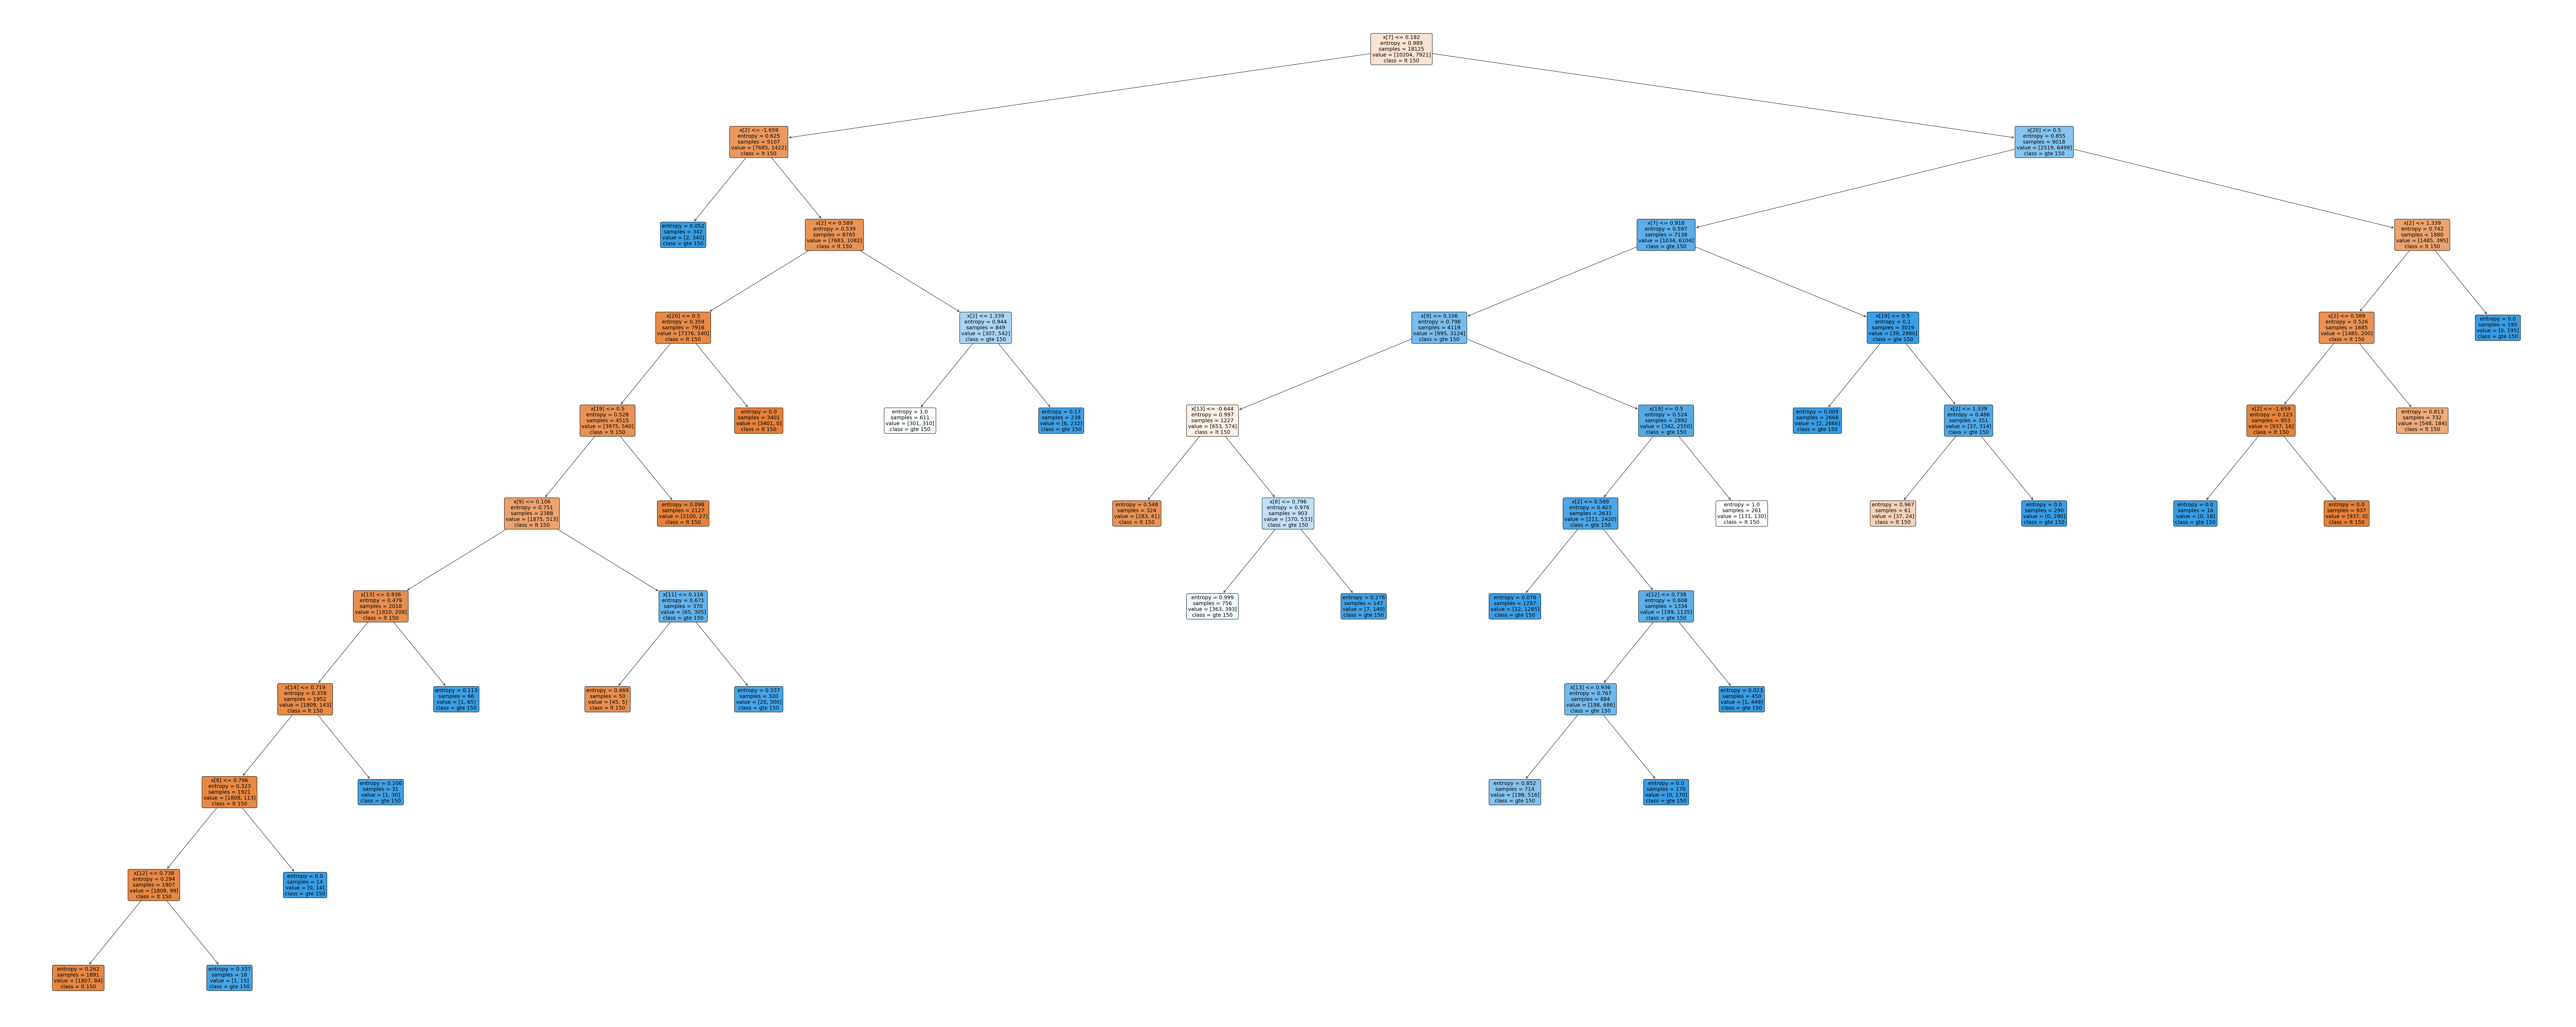

In [18]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(125,50))
tree = plot_tree(grid_search.best_estimator_,
              class_names=['lt 150', 'gte 150'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

### 4.4  Neural Network 

### 4.4.1 Neural Net Random Search CV 

Conduct an initial random search across a wide range of possible parameters.

In [36]:
score_measure = "recall"
kfolds = 3

param_grid = {
    'hidden_layer_sizes': [(60,40, 20), (70,50,40)],
    'activation': [ 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [.2, .5, 1],
    'learning_rate': ['constant', 'invscaling'],
    'learning_rate_init': [0.1, 0.2],
    'max_iter': [50]
}

ann = MLPClassifier()
rand_search = RandomizedSearchCV(estimator = ann, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

bestRecallTree = rand_search.best_estimator_

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 3 folds for each of 96 candidates, totalling 288 fits
The best recall score is 0.9460922649440257
... with parameters: {'solver': 'sgd', 'max_iter': 50, 'learning_rate_init': 0.2, 'learning_rate': 'constant', 'hidden_layer_sizes': (70, 50, 40), 'alpha': 0.5, 'activation': 'tanh'}


### 4.4.2 Neural Net Grid Search CV 

Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [37]:
score_measure = "recall"
kfolds = 5

hidden_layer_sizes = rand_search.best_params_['hidden_layer_sizes']
activation = rand_search.best_params_['activation']
solver = rand_search.best_params_['solver']
alpha = rand_search.best_params_['alpha']
learning_rate = rand_search.best_params_['learning_rate']
learning_rate_init = rand_search.best_params_['learning_rate_init']
max_iter = rand_search.best_params_['max_iter']

param_grid = {
    'hidden_layer_sizes': [hidden_layer_sizes],  
    'activation': [activation],
    'solver': [solver],
    'alpha': np.arange(alpha,alpha+1,0.5),
    'learning_rate': [learning_rate],
    'learning_rate_init': np.arange(learning_rate_init-0.2,learning_rate_init+0.2,0.1),
    'max_iter' : np.arange(max_iter-50,max_iter+50,25)
}

ann = MLPClassifier()
grid_search = GridSearchCV(estimator = ann, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallNeuralNet = grid_search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
The best recall score is 0.9338459516298633
... with parameters: {'activation': 'tanh', 'alpha': 0.5, 'hidden_layer_sizes': (70, 50, 40), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'max_iter': 25, 'solver': 'sgd'}


In [38]:
c_matrix_nn = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix_nn[1][1]
TN = c_matrix_nn[0][0]
FP = c_matrix_nn[0][1]
FN = c_matrix_nn[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Neural Net", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

## 4.5 Keras Technique

In [23]:
# Define recall metric function
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#Define the model
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=23))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile model
#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[recall])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100)

def build_clf(hidden_layer_sizes, dropout):
    ann = tf.keras.models.Sequential()
    ann.add(keras.layers.Input(shape=23)),
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, kernel_initializer= tf.keras.initializers.GlorotUniform(), 
                                     bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    ann.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    ann.compile(loss = 'binary_crossentropy', metrics = [recall])
    return ann

Epoch 1/20
182/182 [==============================] - 2s 6ms/step - loss: 0.2297 - recall: 0.8830 - val_loss: 0.1807 - val_recall: 0.8585
Epoch 2/20
182/182 [==============================] - 1s 5ms/step - loss: 0.1544 - recall: 0.9189 - val_loss: 0.1543 - val_recall: 0.8973
Epoch 3/20
182/182 [==============================] - 1s 5ms/step - loss: 0.1342 - recall: 0.9225 - val_loss: 0.1357 - val_recall: 0.9182
Epoch 4/20
182/182 [==============================] - 1s 5ms/step - loss: 0.1285 - recall: 0.9260 - val_loss: 0.1324 - val_recall: 0.9286
Epoch 5/20
182/182 [==============================] - 1s 5ms/step - loss: 0.1171 - recall: 0.9286 - val_loss: 0.1305 - val_recall: 0.9336
Epoch 6/20
182/182 [==============================] - 1s 5ms/step - loss: 0.1131 - recall: 0.9338 - val_loss: 0.1292 - val_recall: 0.9346
Epoch 7/20
182/182 [==============================] - 1s 6ms/step - loss: 0.1045 - recall: 0.9338 - val_loss: 0.1248 - val_recall: 0.9425
Epoch 8/20
182/182 [==============

### 4.5.1 Keras Technique Random Search CV

Conduct an initial random search across a wide range of possible parameters.

In [24]:
score_measure = recall
kfolds = 3

param_grid = {
    'optimizer__learning_rate': [0.0005, 0.001],
    'model__hidden_layer_sizes': [(70,),(90, )],
    'model__dropout': [0, 0.1],
    'batch_size':[20,60],
    'epochs':[5,10],
    'optimizer':["adam",'sgd']
}

keras_clf = KerasClassifier(model=build_clf, hidden_layer_sizes=23, dropout = 0.0)
keras_clf.get_params().keys()

rand_search = RandomizedSearchCV(estimator=keras_clf, param_distributions=param_grid, scoring=score_measure, 
                                 n_iter=10, cv=kfolds)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
callback = [earlystop]

_ = rand_search.fit(X_train, y_train, callbacks=callback, verbose=0)

print(f"The best recall score is with parameters: {rand_search.best_params_}")

bestRecallKeras = rand_search.best_estimator_

The best recall score is with parameters: {'optimizer__learning_rate': 0.0005, 'optimizer': 'adam', 'model__hidden_layer_sizes': (90,), 'model__dropout': 0.1, 'epochs': 5, 'batch_size': 20}


In [26]:
c_matrix = confusion_matrix(y_test, rand_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]

389/389 [==============================] - 1s 1ms/step


In [27]:
performance = pd.concat([performance, pd.DataFrame({'model':"Keras", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### Best Estimators for the 5 models

In [28]:
bestRecallLogistic

LogisticRegression(max_iter=677, penalty='l1', solver='liblinear')

In [29]:
bestRecallSVM

SVC(C=17, gamma='auto')

In [30]:
bestRecallTree

MLPClassifier(activation='tanh', alpha=0.2, hidden_layer_sizes=(70, 50, 40),
              learning_rate_init=0.1, max_iter=5000, solver='sgd')

In [31]:
bestRecallNeuralNet

MLPClassifier(activation='tanh', alpha=0.2, hidden_layer_sizes=(70, 50, 40),
              learning_rate_init=0.1, max_iter=4950, solver='sgd')

In [32]:
bestRecallKeras

KerasClassifier(
	model=<function build_clf at 0x0000016383110AF0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=20
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=5
	hidden_layer_sizes=23
	dropout=0.0
	optimizer__learning_rate=0.0005
	model__hidden_layer_sizes=(90,)
	model__dropout=0.1
	class_weight=None
)

## 5.0 Summary of the models

Sorted by recall, the best models are:

In [33]:
performance.sort_values(by=['Recall'])

,model,Accuracy,Precision,Recall,F1
0,Keras,0.868692,0.872007,0.824913,0.847807
0,Logistic Regression,0.869979,0.870134,0.830720,0.849970
0,SVM,0.946576,0.950342,0.927991,0.939033
0,Decision Tree,0.946576,0.950342,0.927991,0.939033
0,Neural Net,0.946189,0.940851,0.937573,0.939209


## Discussion on how MLP and Keras sequential model performed with respect to previous models.

After looking at the recall values we figure out that the MLP Neural Net performed better than all the other models with the recall value of 93.75%.However, Keras sequential model did not perform well and had a recall value of 82.49%.

### By checking all the algorithms, we figured out that the best value of recall comes from the Neural Net Algorithm i.e. 93.75%.

In [39]:
TP = c_matrix_nn[1, 1] 
TN = c_matrix_nn[0, 0] 
FP = c_matrix_nn[0, 1] 
FN = c_matrix_nn[1, 0] 
confusion_perc = c_matrix_nn/14574 
rf_result = confusion_perc * 50000
p_and_l = np.array([[TN_profit, FP_profit],[FN_profit, TP_profit]])
rf_result * p_and_l
model_profit = (rf_result * p_and_l).sum()
model_profit
print(f"${model_profit:,.2f}")

$511,270.07


## 6.0 Business Impact Summary

The airline company offered 25976 existing firms the coupon. Of the 25976 firms, 11402 were satisfied. Since the airline company has to give \\$45 coupon to the passenger. The airline company's profit from getting a passenger to fly with them turns out to be \\$55 but if the passenger doesnt shows up or is not satisfied the airline company has to pay \\$45 ultimately resulting in a loss of  \\$28720. If this 'null model' approach were used on the remaining 50,000 customers, this would result in a loss of \\$55281. 

Using different modelling techniques I figured out that the Neural Net model had the best recall value at 93.75% and outperformed all the other models.
Using Neural Net with hyperparameters on the airline passenger satisfaction dataset, the expected total profit resulted out to be \\$511,270.07 which is way better than the null model value.

Based on the expected performance of the proposed model, the Airline company could proceed with implementing a profitable business. However, the data shows a significant imbalance as there are high values of the passenger who will not be satisfied. If we could reduce the negative effect of the unbalanced data set, there is an opportunity to develop a better-performing model resulting in greater profit for the Airline company.